## 강화학습 흐름
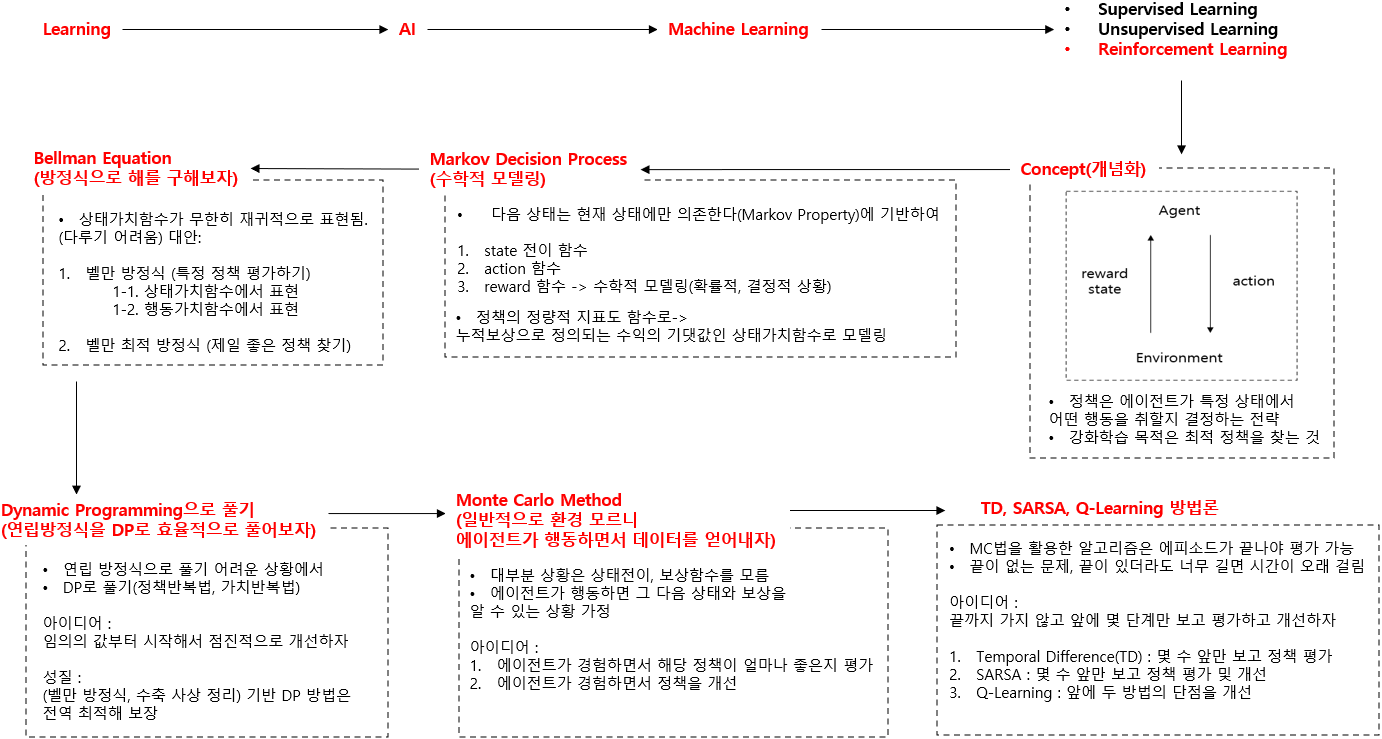
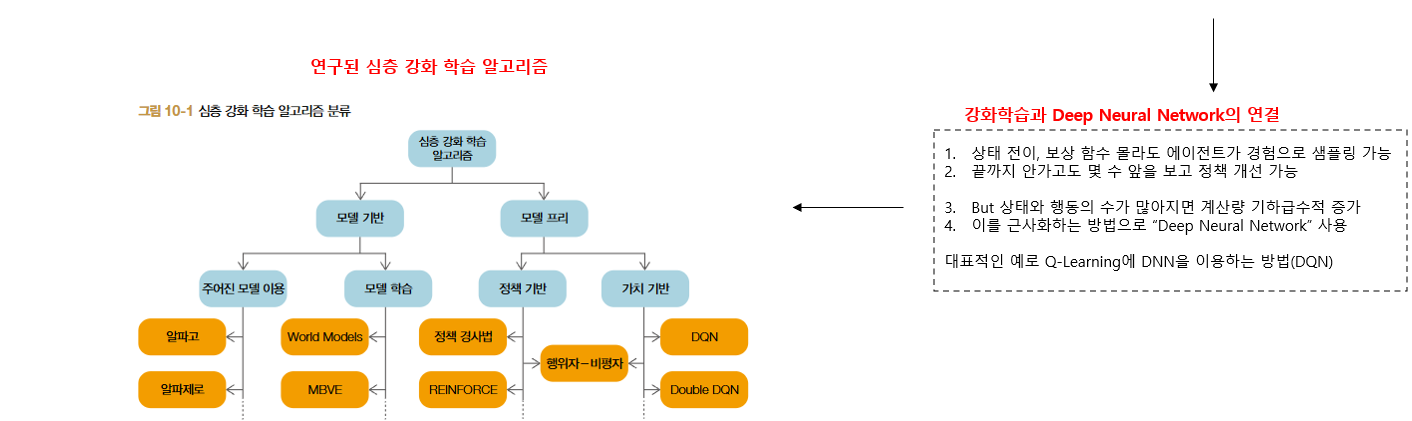

# 
#### 이번 장에서는 신경망과 강화학습 알고리즘을 결합한 심층 강화 학습 알고리즘을 구현해보고자함.
1. 신경망은 DeZero 라는 라이브러리를 활용,
2. 강화학습 알고리즘은 Q 러닝을 이용

- 이 둘을 결합하여 DQN을 구현해볼 것임.

# 
### 1. 먼저 신경망 Dezero 사용 간단히
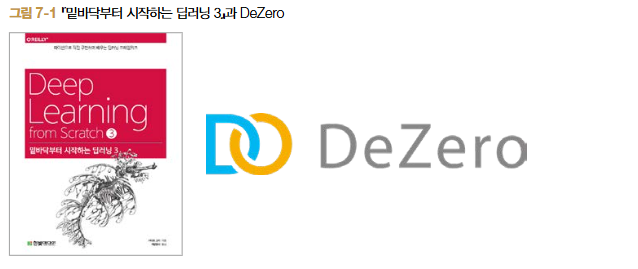

#### DeZero :
- 파이토치를 기반으로 알기 쉽게 설계된 프레임워크임.
- Dezero는 GPU, CPU를 사용하여 신경망을 설계하고 학습할 수 있는 라이브러리임.

간단한 비선형회귀를 신경망으로 근사화해보는 문제를 풀어볼 것임

만약 Dezero np.int 오류가 난다면 anaconda3->lib->site-packages->Dezero->Transforms.py 파일 안에 np.int 를 찾아서 int 로 수정만하면됨.

In [1]:
!pip install dezero

In [3]:
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.layers as L
import dezero.functions as F
import matplotlib.pyplot as plt

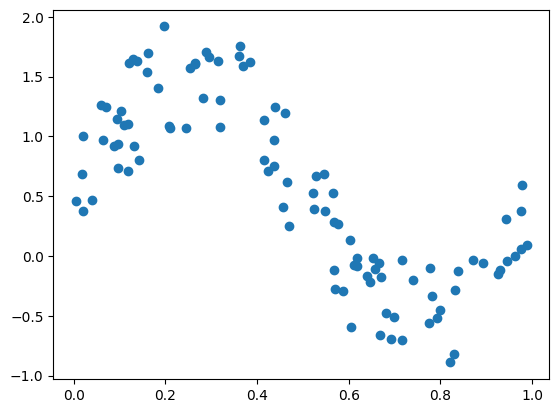

In [4]:
# 데이터셋 생성
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1)

plt.scatter(x, y)
plt.show()

In [5]:
lr = 0.2
iters = 10000

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(10,1)
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    optimizer.update()
    if i % 1000 == 0:
        print(i, loss)

0 variable(0.8165178479901415)
1000 variable(0.2499028014603372)
2000 variable(0.24609874026436834)
3000 variable(0.23721586110833612)
4000 variable(0.2079321799482215)
5000 variable(0.12311919860580513)
6000 variable(0.07888168390348675)
7000 variable(0.07656075297857301)
8000 variable(0.07643364647799139)
9000 variable(0.0761937449484299)


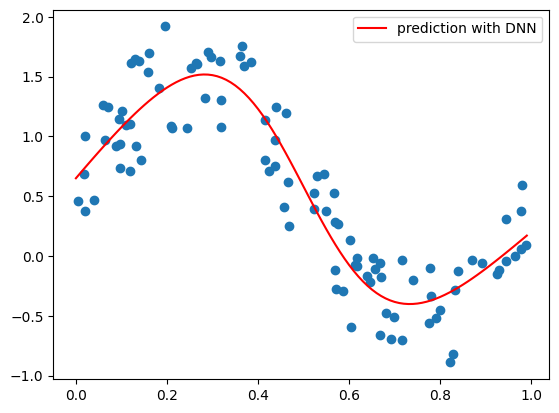

In [6]:
# 데이터셋 생성
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1)

data = np.arange(0,1, 0.01)
data = np.reshape(data, (-1,1))

y_pred_variable = model(data)
y_pred = y_pred_variable.data # <--- This is the crucial line

plt.scatter(x, y)
plt.plot(data, y_pred, color='r', label='prediction with DNN')
plt.legend()
plt.show()

# 
### 2. Q러닝과 신경망
- 신경망은 데이터 기반 유연한 함수 근사화 방법임.
- 강화학습 알고리즘에 신경망 근사화 방법을 적용한 분야가 "심층 강화학습" 분야임.
- 우리는 강화학습 알고리즘 중 가장 많이 사용되고 알려진 "Q 러닝" 에 대해 신경망으로 근사화해볼 것임.

- 이때까지 다룬 3x4 그리드월드처럼 Q러닝에서 Q 테이블은 
    1. 상태 후보가 12개
    2. 행동 후보가 각 상태에 4개 (동서남북)이므로
- Q 테이블은 총 12X4 = 48개 였음.
- 이 정도를 이전 장에서는 파이썬 코드에서 딕셔너리로 보관하고 다루었음.
- 하지만 상태와 행동이 일반적으로 많은 경우에는 저장 메모리와 계산량에 부딪히게됨.

- 신경망은 Q러닝의 이러한 문제를 줄여주면서도 여전히 유효한 좋은 정책을 찾아줄 수 있는 방법으로 활용할 것임.

#### 무엇을 근사화할 것인가?
- Q 러닝의 수식은 다음과 같았음.
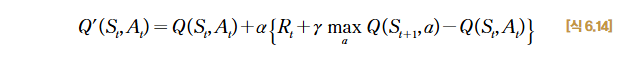
- Q 러닝에서 상태와 행동의 수에 따라 계산량이 커지므로 2가지를 생각해볼 수 있음
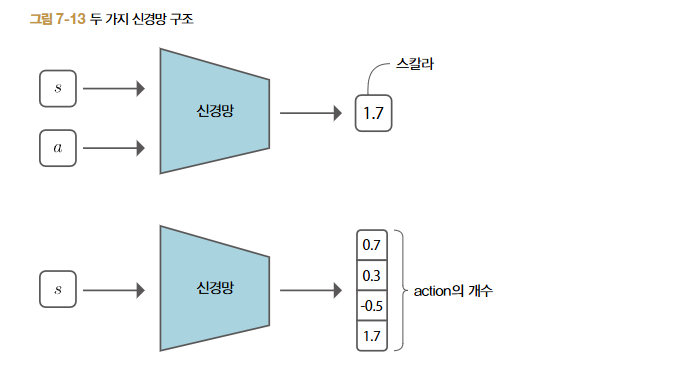

1. 상태 s 와 행동 a 를 신경망의 입력으로 넣어 Q 함수의 값을 출력하도록 설계
    - 즉 $s, a$ 를 넣어 $Q(s,a)$ 값을 출력할 것인가?
2. 상태 s 를 신경망의 입력으로 넣어 행동 a 형태를 출력하도록 설계
    - 아니면 $s$ 를 넣어 $a$ 를 출력하도록 할 것인가? 

- 첫 번째 경우에는 상태 경우의 수 X 행동 경우의 수 이므로 경우의 수가 커질 우려가 있음.
- 이번 구현에서는 2번째 방법을 선택해볼 것임.

#### Step 1. 신경망의 입력으로 상태 $s$ 을 어떻게 표현할 것인가?
- 한 가지 방법으로 각 모든 상태를 one hot 인코딩으로 표현

In [7]:
def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    return vec[np.newaxis, :]

In [9]:
state = (2,0)
x = one_hot(state)
print(x.shape)
print(x)

(1, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


#### Step 2. 상태 s를 입력으로받아 4가지 행동 a로 출력하는 Q net 설계

In [20]:
class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)  # 중간층의 크기
        self.l2 = L.Linear(4)    # 행동의 크기(가능한 행동의 개수)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [21]:
qnet = QNet()
state = (2,0)
state = one_hot(state)

qs = qnet(state)
print(qs.shape)
state, qs

(1, 4)


(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32),
 variable([[0.51507061 0.42083814 0.48131592 0.53314423]]))

#### Step 3. Q러닝 에이전트 설계
- Q러닝 수식을 복습해보면
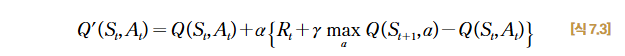
- 레이블처럼 여길 수 있는 값을 $T$ 로 표기하면
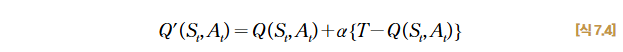

In [22]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()                        # 신경망 초기화
        self.optimizer = optimizers.SGD(self.lr)  # 옵티마이저 생성
        self.optimizer.setup(self.qnet)           # 옵티마이저에 신경망 등록

    def get_action(self, state_vec):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state_vec)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        # 다음 상태에서 최대가 되는 Q 함수의 값(next_q) 계산
        if done:  # 목표 상태에 도달
            next_q = np.zeros(1)  # [0.]  # [0.] (목표 상태에서의 Q 함수는 항상 0)
        else:     # 그 외 상태
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()  # next_q를 역전파 대상에서 제외

        # 목표
        target = self.gamma * next_q + reward
        # 현재 상태에서의 Q 함수 값(q) 계산
        qs = self.qnet(state)
        q = qs[:, action]
        # 목표(target)와 q의 오차 계산
        loss = F.mean_squared_error(target, q)

        # 역전파 → 매개변수 갱신
        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data

# 
### Q 러닝 학습 및 시각화
- 먼저 그리드월드 코드

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict


class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)    # 목표 상태(좌표)
        self.wall_state = (1, 1)    # 벽 상태(좌표)
        self.start_state = (2, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)
        
        
class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

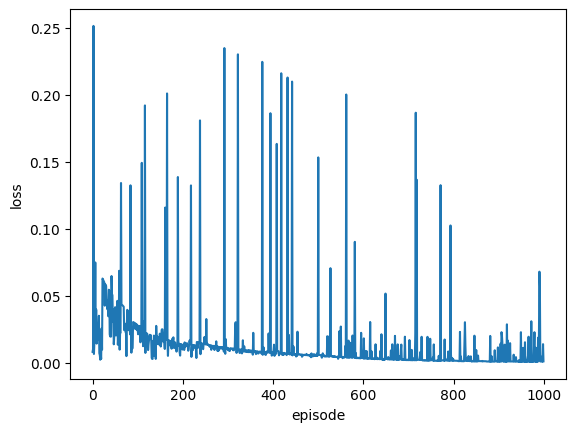

C:\Users\brigh\AppData\Local\Temp\ipykernel_21932\983712931.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] = float(q.data)


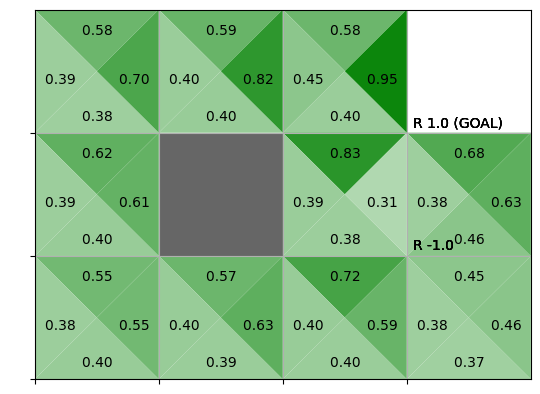

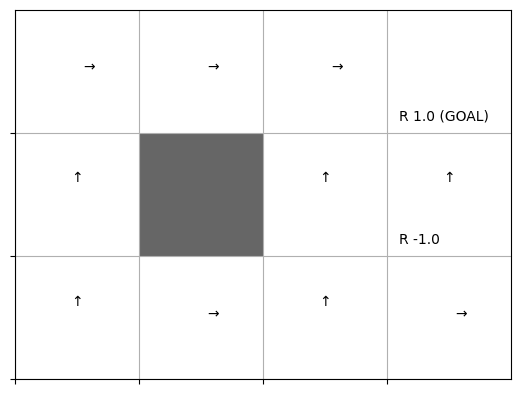

In [24]:
env = GridWorld()
agent = QLearningAgent()

episodes = 1000  # 에피소드 수
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)


# [그림 7-14] 에피소드별 손실 추이
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

# [그림 7-15] 신경망을 이용한 Q 러닝으로 얻은 Q 함수와 정책
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
        print(f"현재 상태: {state}, 행동: {action}, Q 값: {q.data}")
env.render_q(Q)

In [25]:
q.data

array([0.45667131])